In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

from pytraction.core import TractionForce
from pytraction.utils import plot

# Example 1 

Basic showing usage with and image stack and reference

In [7]:
pix_per_mu = 1.3
E = 100 # Young's modulus in Pa

img_path = '../data/example1/e01_pos1_axon1.tif'
ref_path = '../data/example1/e01_pos1_axon1_ref.tif'

traction_obj = TractionForce(pix_per_mu, E=E, window_size=32)

img, ref, _ = traction_obj.load_data(img_path, ref_path)

log1 = traction_obj.process_stack(img, ref)

print(log1)

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [362, 641])
('     ', 'total number of iterations', ' | ', 1)
('     ', 'overlap ratio', ' | ', 0.5)
('     ', 'coarse factor', ' | ', 0)
('     ', 'time step', ' | ', 1.0)
('     ', 'validation method', ' | ', 'mean_velocity')
('     ', 'number of validation iterations', ' | ', 3)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([21], dtype=int32))
('     ', 'Ncol', ' | ', array([39], dtype=int32))
('     ', 'Window sizes', ' | ', array([32], dtype=int32))
-----------------------------------
|   

   11        19595.6     -13245.4        parabolic
   12        17135.7       -13244        golden
   13        19096.6     -13245.6        parabolic
   14        19021.7     -13245.6        parabolic
   15          18985     -13245.6        parabolic
   16        18987.4     -13245.6        parabolic
   17        18987.5     -13245.6        parabolic
   18        18987.5     -13245.6        parabolic
   19        18987.5     -13245.6        parabolic
   20        18987.5     -13245.6        parabolic
   21        18987.5     -13245.6        golden
   22        18987.5     -13245.6        golden
   23        18987.5     -13245.6        golden
   24        18987.5     -13245.6        golden
   25        18987.5     -13245.6        golden
   26        18987.5     -13245.6        golden
   27        18987.5     -13245.6        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
Time taken 0.2378098964691162 s
---------

..[DONE]
(' --residual : ', 0.9999999845027926)
Starting validation..
('Validation, iteration number ', 0)
 
('Validation, iteration number ', 1)
 
('Validation, iteration number ', 2)
 
..[DONE]
 
//////////////////////////////////////////////////////////////////
end of iterative process.. Re-arranging vector fields..
...[DONE]
-------------------------------------------------------------
('[DONE] ..after ', 10.557256937026978, 'seconds ')
-------------------------------------------------------------
Optimizing Lambda
 
 Func-count     x          f(x)          Procedure
    1         381966     -10746.4        initial
    2         618034     -10738.7        golden
    3         236068     -10756.5        golden
    4         145898     -10769.1        golden
    5        90169.9     -10783.5        golden
    6        55728.1     -10798.5        golden
    7        34441.9     -10811.4        golden
    8        21286.2     -10818.3        golden
    9        13155.6     -10814.2    

..[DONE]
(' --residual : ', 0.9999999899666933)
Starting validation..
('Validation, iteration number ', 0)
 
('Validation, iteration number ', 1)
 
('Validation, iteration number ', 2)
 
..[DONE]
 
//////////////////////////////////////////////////////////////////
end of iterative process.. Re-arranging vector fields..
...[DONE]
-------------------------------------------------------------
('[DONE] ..after ', 34.15408802032471, 'seconds ')
-------------------------------------------------------------
Optimizing Lambda
 
 Func-count     x          f(x)          Procedure
    1         381966     -9363.64        initial
    2         618034     -9362.57        golden
    3         236068     -9365.22        golden
    4         145898     -9367.44        golden
    5        90169.9      -9370.3        golden
    6        55728.1     -9373.55        golden
    7        34441.9     -9376.41        golden
    8        21286.2     -9377.32        golden
    9        9861.76     -9367.94     

..[DONE]
(' --residual : ', 0.9999999976551472)
Starting validation..
('Validation, iteration number ', 0)
 
('Validation, iteration number ', 1)
 
('Validation, iteration number ', 2)
 
..[DONE]
 
//////////////////////////////////////////////////////////////////
end of iterative process.. Re-arranging vector fields..
...[DONE]
-------------------------------------------------------------
('[DONE] ..after ', 57.45888900756836, 'seconds ')
-------------------------------------------------------------
Optimizing Lambda
 
 Func-count     x          f(x)          Procedure
    1         381966     -10465.3        initial
    2         618034     -10464.7        golden
    3         236068       -10466        golden
    4         145898     -10466.6        golden
    5        90169.9     -10466.6        golden
    6         109134     -10466.7        parabolic
    7         115687     -10466.7        parabolic
    8         110916     -10466.7        parabolic
    9         110318     -104

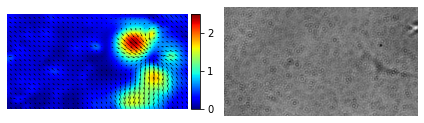

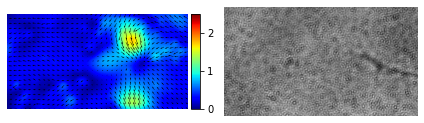

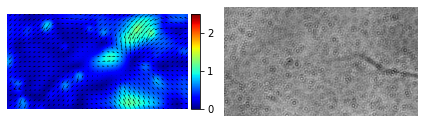

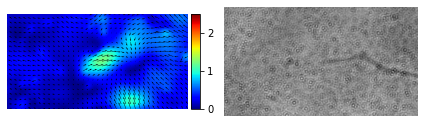

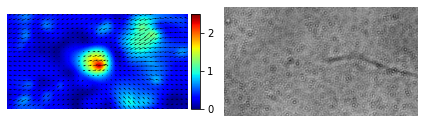

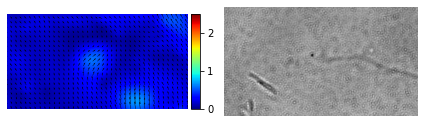

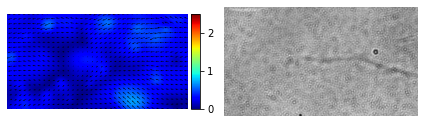

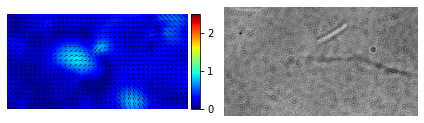

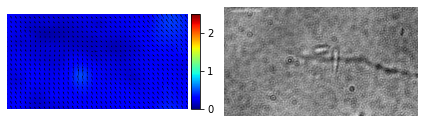

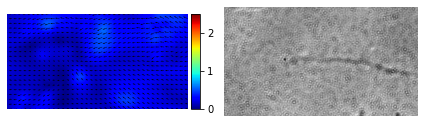

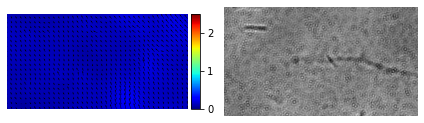

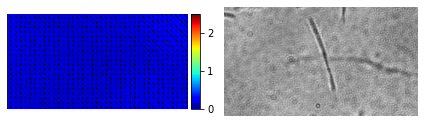

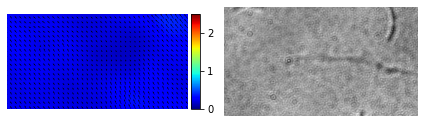

In [12]:
for frame in range(len(log1)):
    plot(log1, frame=frame, fmax_plot=2.5)

# Example 2

Usage using an image and reference with an ROI. This can help approximating the noise 

In [18]:
pix_per_mu = 9.8138
E = 1000 # Young's modulus in Pa

img_path = '../data/example2/1kPa-2-Position006.tif'
ref_path = '../data/example2/1kPa-2-Position006_ref.tif'
roi_path = '../data/example2/1kPa-2-Position006.roi'

traction_obj = TractionForce(pix_per_mu, E=E, window_size=64)

img, ref, roi = traction_obj.load_data(img_path, ref_path, roi_path)

log2 = traction_obj.process_stack(img, ref, roi=roi)

print(log2)

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [657, 767])
('     ', 'total number of iterations', ' | ', 1)
('     ', 'overlap ratio', ' | ', 0.5)
('     ', 'coarse factor', ' | ', 0)
('     ', 'time step', ' | ', 1.0)
('     ', 'validation method', ' | ', 'mean_velocity')
('     ', 'number of validation iterations', ' | ', 3)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([19], dtype=int32))
('     ', 'Ncol', ' | ', array([22], dtype=int32))
('     ', 'Window sizes', ' | ', array([64], dtype=int32))
-----------------------------------
|   

..[DONE]
(' --residual : ', 0.9999999839009966)
Starting validation..
('Validation, iteration number ', 0)
 
('Validation, iteration number ', 1)
 
('Validation, iteration number ', 2)
 
..[DONE]
 
//////////////////////////////////////////////////////////////////
end of iterative process.. Re-arranging vector fields..
...[DONE]
-------------------------------------------------------------
('[DONE] ..after ', 6.852687120437622, 'seconds ')
-------------------------------------------------------------
Optimizing Lambda
 
 Func-count     x          f(x)          Procedure
    1         381966          nan        initial
    2         618034          nan        golden
    3         236068          nan        golden
    4         472136          nan        golden
    5         326238          nan        golden
    6         416408          nan        golden
    7         360680          nan        golden
    8         395122          nan        golden
    9         373835          nan     

   13         380780          nan        golden
   14         382699          nan        golden
   15         381513          nan        golden
   16         382246          nan        golden
   17         381793          nan        golden
   18         382073          nan        golden
   19         381900          nan        golden
   20         382007          nan        golden
   21         381941          nan        golden
   22         381982          nan        golden
   23         381956          nan        golden
   24         381972          nan        golden
   25         381962          nan        golden
   26         381968          nan        golden
   27         381965          nan        golden
   28         381967          nan        golden
   29         381965          nan        golden
   30         381966          nan        golden
   31         381966          nan        golden
   32         381966          nan        golden
   33         381966          nan       

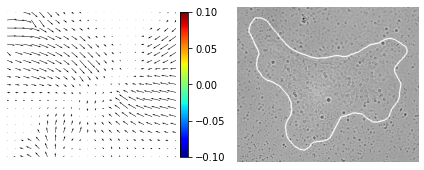

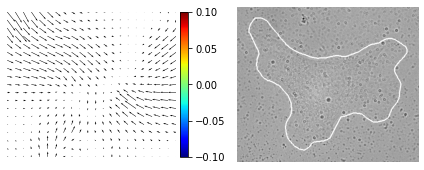

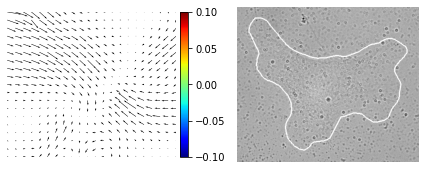

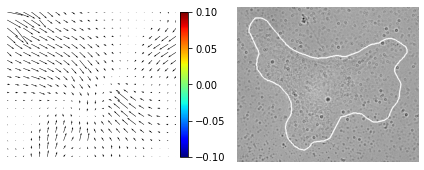

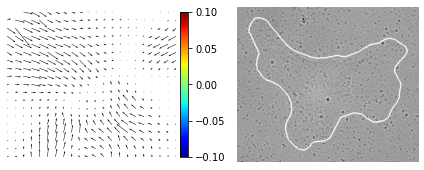

In [19]:
for frame in range(len(log2)):
    plot(log2, frame=frame)

# Example 3

Usage using an image and reference that are the not in the correct format and usage of an experimental automatic ROI detection.

In [23]:
pix_per_mu = 1
E = 3000 # Young's modulus in Pa

img_path_bead = '../data/example3/Beads3.tif'
img_path_cell = '../data/example3/Cell3.tif'
ref_path = '../data/example3/BeadsStop.tif'

def z_project(img_path):
        img = io.imread(img_path)
        img_max= np.max(img, axis=0)
        return img_max

bead = z_project(img_path_bead)
cell = z_project(img_path_cell)
ref = z_project(ref_path)

img = np.stack([[bead, cell]])
ref = np.stack([ref, ref])

io.imsave('../data/example3/tfm.tif', img)
io.imsave('../data/example3/tfm-ref.tif', ref)


img_path = '../data/example3/tfm.tif'
ref_path = '../data/example3/tfm-ref.tif'

traction_obj = TractionForce(pix_per_mu, E=E, segment=True, window_size=16)

img, ref, roi = traction_obj.load_data(img_path, ref_path)

log3 = traction_obj.process_stack(img, ref, roi=roi)

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [258, 193])
('     ', 'total number of iterations', ' | ', 1)
('     ', 'overlap ratio', ' | ', 0.5)
('     ', 'coarse factor', ' | ', 0)
('     ', 'time step', ' | ', 1.0)
('     ', 'validation method', ' | ', 'mean_velocity')
('     ', 'number of validation iterations', ' | ', 3)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([31], dtype=int32))
('     ', 'Ncol', ' | ', array([23], dtype=int32))
('     ', 'Window sizes', ' | ', array([16], dtype=int32))
-----------------------------------
|   

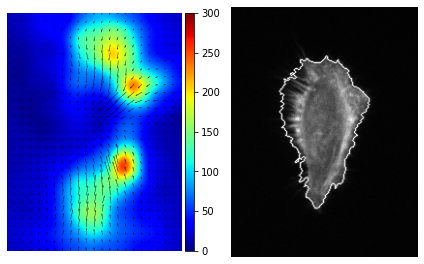

In [24]:
for frame in range(len(log3)):
    plot(log3, frame=frame, fmax_plot=300)